In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import calendar
import geopandas as gpd
from shapely.geometry import Point, Polygon
import scipy as sp
from scipy.stats import chi2
from sklearn.preprocessing import OneHotEncoder, LabelEncoder 
plt.style.use('default')
# import sys
# !conda install --yes --prefix {sys.prefix} scikit-learn
%matplotlib inline

# Import/Clean Accident Data
- Convert all times to datetime stamps
- Add column for years
- Add column for months
- Add column for hour of day

In [2]:
# load data
accident_data = pd.read_csv("updated_accident_data.csv")

# cast cols to appropriate types
accident_data['dispatch_ts'] = pd.to_datetime(accident_data.dispatch_ts)
accident_data['year'] = accident_data['dispatch_ts'].dt.year
accident_data['month'] = accident_data['dispatch_ts'].dt.month
accident_data['hour'] = accident_data['dispatch_ts'].dt.hour
accident_data['weekday'] = accident_data['dispatch_ts'].dt.dayofweek
accident_data['day'] = accident_data['dispatch_ts'].dt.day
accident_data['date'] = accident_data['dispatch_ts'].dt.date
accident_data['month_name'] = accident_data['month'].apply(lambda x: calendar.month_abbr[x])

enc = OneHotEncoder(handle_unknown='ignore')
le = LabelEncoder() 
accident_data['mode_type']= le.fit_transform(accident_data['mode_type'])
enc_df = pd.DataFrame(enc.fit_transform(accident_data[['mode_type']]).toarray())
enc_df.rename(columns = {0:'bike', 1:'mv', 2:'ped'}, inplace = True)
accident_data = accident_data.join(enc_df)

In [3]:
# define global vars
years = accident_data['year'].unique()
months = accident_data['month'].unique()
hours = accident_data['hour'].unique()
modes = accident_data['mode_type'].unique()
loc_types = accident_data['location_type'].unique()
weekdays = accident_data['weekday'].unique()
month_names = accident_data['month_name'].unique()

# Import/Clean Weather Data

In [4]:
weather_data = pd.read_csv("weather_data.csv")
weather_data = weather_data.drop(columns=["STATION", "NAME"])

In [5]:
weather_data['DATE'] = pd.to_datetime(weather_data.DATE)
weather_data['MONTH'] = weather_data['DATE'].dt.month
weather_data['WEEKDAY'] = weather_data['DATE'].dt.dayofweek

# Data Prepping/Filtering Functions

In [6]:
def points_in_region(pts):
    crs = {'init': 'epsg:4326'}

    # Create a geoseries holding the single polygon. Coordinates in counter-clockwise order
    poly = Polygon(pts)
    spoly = gpd.GeoSeries([poly],crs=crs)

    # Create geodataframe of points
    geometry = [Point(xy) for xy in zip(accident_data['long'], accident_data['lat'])]
    dfpoints = gpd.GeoDataFrame(accident_data, crs=crs, geometry=geometry)

    # Create a subset dataframe of points within the polygon
    subset = dfpoints[dfpoints.within(spoly.geometry.iloc[0])]

    return subset

In [7]:
def groupby_implementation_date(df, implementation_date):
    # calculate dist to implementation date
    temp = list(df['dispatch_ts'].dt.tz_localize(None) - datetime.strptime(implementation_date, '%Y-%m-%d'))
    temp = [pt.days for pt in temp]
    df["date_diff"] = temp
    df["count"] = 1
    
    # group accidnets by day before/after
    df_group = df.groupby(['date_diff']).count()['count'].reset_index()
    
    # num days beofre policy data collected
    num_days_before = (datetime.strptime(implementation_date, '%Y-%m-%d') -
                      datetime.strptime("2015-01-01", '%Y-%m-%d')).days
    
    # num days after policy data collected
    num_days_after = (datetime.strptime("2019-12-31", '%Y-%m-%d') -
                      datetime.strptime(implementation_date, '%Y-%m-%d')).days
    
    # pick the smaller of the two 
    num_days = min(num_days_before, num_days_after)
    
    # determine dates of start and end
    start = (datetime.strptime(implementation_date, '%Y-%m-%d') - timedelta(num_days)).date()
    end = (datetime.strptime(implementation_date, '%Y-%m-%d') + timedelta(num_days)).date()
    
    # fill any missing days with 0 count
    x = pd.DataFrame({"date_diff": list(range(-num_days,num_days + 1)), 
                      "date": pd.date_range(start=start,end=end)})
    
    df_group = x.set_index('date_diff')\
                            .join(df_group.set_index("date_diff"))\
                            .fillna(0).reset_index()
            
    return df_group

# Mahalanobis Distance - Covariate Imbalance Test
Links: https://www.machinelearningplus.com/statistics/mahalanobis-distance/

In [8]:
def mahalanobis(randomization, num_days):
    
    weather_subset = pd.DataFrame({"date": list(randomization["date"])})

    weather_subset = weather_subset.set_index('date')\
                            .join(weather_data.set_index('DATE')).reset_index()
    
    weather_subset = weather_subset.drop(columns=['date'])
    
    ctrl_mu = weather_subset[:num_days]
    treat_mu = weather_subset[num_days + 1:]
    X = ctrl_mu.append(treat_mu)
    
    mean_diff = np.array(treat_mu.mean() - ctrl_mu.mean())
    mean_diff_T = mean_diff.T
    
    cov_matrix = np.cov(X.T)
    if np.linalg.det(cov_matrix) == 0:
        try:
            cov_matrix_inv = np.linalg.pinv(np.cov(X.T))
        except:
            return 10000000
    else:
        cov_matrix_inv = np.linalg.inv(np.cov(X.T))
    
    left_term = np.dot(mean_diff_T, cov_matrix_inv)
    
    dist = (num_days / 2) * np.dot(left_term, mean_diff)
    
    return dist

# Fisherian Analysis 

In [9]:
# fisher withOUT mahalanobis distance
def fisherian_test(df, num_days):

    tobs = 0
    t_vals = []
    last_date = len(df) - (num_days + 1)

    for date in range(num_days, last_date + 1):
        df_pre = df.iloc[date - num_days : date]
        df_post= df.iloc[date + 1 : date + num_days + 1]
        t_vals.append(np.mean(df_post["count"]) - np.mean(df_pre["count"]))
        if df.iloc[date]["date_diff"] == 0:
            tobs = t_vals[-1]
    
    p_val = len([i for i in t_vals if i >= tobs]) / len(t_vals)
    
    return t_vals, tobs, p_val

In [10]:
# fisher WITH mahalanobis distance
def fisherian_mahalanobis_test(df, num_days):
    
    last_date = len(df) - (num_days + 1)
    num_rands = (len(df) - num_days) - (num_days + 1) + 1
    
    dist_df = pd.DataFrame({"dist": [0] * num_rands})
    dists = []
    
    # iterate through all rands and get mahalanobis dist
    for i in range(num_rands):
        dists.append(mahalanobis(df[i: i + (2 * num_days) + 1], num_days))
        
    dist_df["dist"] = dists
    
    # cut off for distances
    quantile_cutoff = dist_df["dist"].quantile(.75)
    
    # iterate through rands to calc t_val
    t_vals = []
    tobs = 0
    
    
    for date in range(num_days, last_date + 1):
        if (dist_df.iloc[date - num_days]["dist"] < quantile_cutoff) or (df.iloc[date]["date_diff"] == 0):
            df_pre = df.iloc[date - num_days : date]
            df_post= df.iloc[date + 1 : date + num_days + 1]
            t_vals.append(np.mean(df_post["count"]) - np.mean(df_pre["count"]))
            if df.iloc[date]["date_diff"] == 0:
                tobs = t_vals[-1]
                
    p_val = len([i for i in t_vals if i >= tobs]) / len(t_vals)
    
    return t_vals, tobs, p_val

# Visualizations

In [11]:
def generate_accident_spread(diff_day_df):
    plt.scatter(diff_day_df["date_diff"],diff_day_df["count"])
    plt.axvline(x=0)
    plt.xlabel("Days before and after policy implemented on day 0")
    plt.ylabel("Num Accidents")
    plt.title("Num Accidents")
    plt.show()

In [12]:
def generate_hist(t_vals, tobs, num_days):
    plt.hist(t_vals)
    plt.axvline(x=tobs, color="red")
    plt.xlabel("Difference in Means of Accidents")
    plt.ylabel("Frequency")
    plt.title("Distribution in t-vals for " +str(num_days) + " Day Pre/Post Analysis")
    plt.show()

In [13]:
def generate_results(diff_day, intv_val):
    t_vals, tobs, p_val = fisherian_test(diff_day, intv_val)
    generate_hist(t_vals, tobs, intv_val)
    return p_val, tobs

In [14]:
def generate_mahalanobis_results(diff_day, intv_val):
    t_vals, tobs, p_val = fisherian_mahalanobis_test(diff_day, intv_val)
    generate_hist(t_vals, tobs, intv_val)
    return p_val, tobs

# City-Wide Speed Limit Reduction

In [15]:
implementation_date = '2017-01-09'
boston_data = accident_data.copy(deep=True)
boston_diff_day = groupby_implementation_date(boston_data, implementation_date)

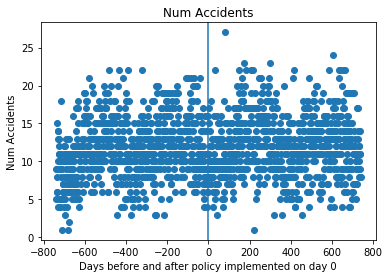

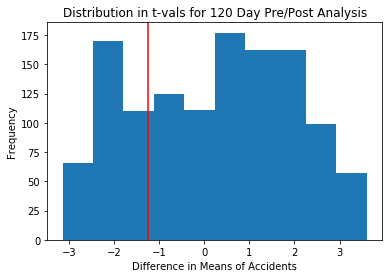

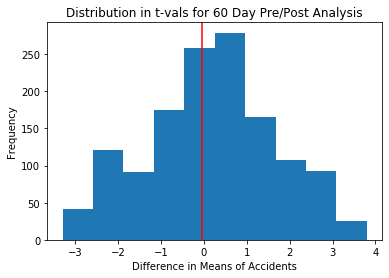

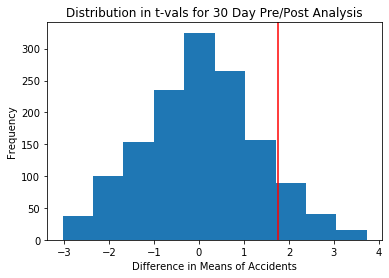

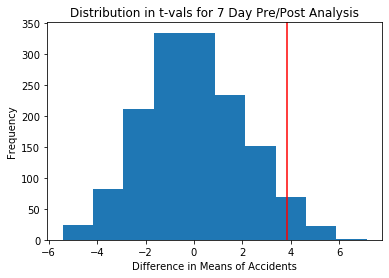

/Users/akshitharamachandran/anaconda3/envs/geopandas-test/lib/python3.7/site-packages/numpy/linalg/linalg.py:2125: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


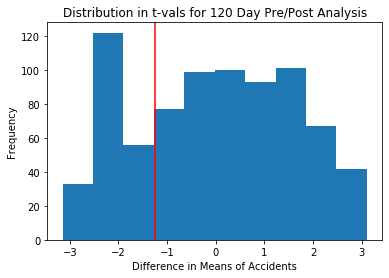

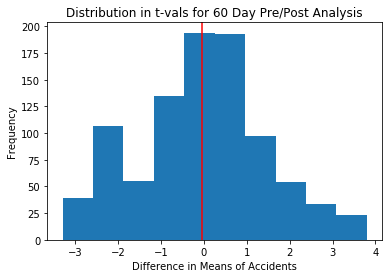

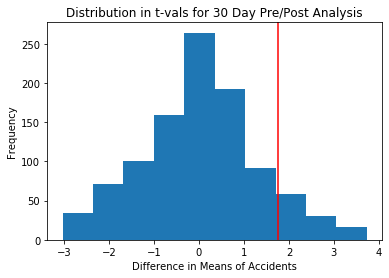

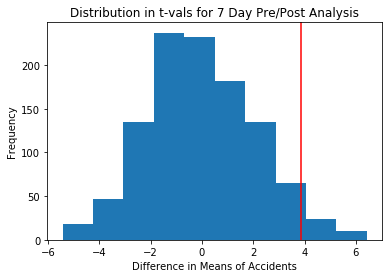

,interval,p_val,t_obs,p_val_filter,t_obs_filter
0,120 days,0.737692,-1.241667,0.732911,-1.241667
1,60 days,0.568065,-0.050000,0.508056,-0.050000
2,30 days,0.097956,1.766667,0.097441,1.766667
3,7 days,0.041638,3.857143,0.040553,3.857143


In [16]:
# plot results
generate_accident_spread(boston_diff_day)
p120, t120 = generate_results(boston_diff_day, 120)
p60, t60 = generate_results(boston_diff_day, 60)
p30, t30 = generate_results(boston_diff_day, 30)
p7, t7 = generate_results(boston_diff_day, 7)

# plot results for filtered data
p120_ft, t120_ft = generate_mahalanobis_results(boston_diff_day, 120)
p60_ft, t60_ft = generate_mahalanobis_results(boston_diff_day, 60)
p30_ft, t30_ft = generate_mahalanobis_results(boston_diff_day, 30)
p7_ft, t7_ft = generate_mahalanobis_results(boston_diff_day, 7)

data = [["120 days", p120, t120, p120_ft, t120_ft], 
        ["60 days", p60, t60, p60_ft, t60_ft], 
        ["30 days", p30, t30, p30_ft, t30_ft], 
        ["7 days", p7, t7, p7_ft, t7_ft]]
boston_df = pd.DataFrame(data, columns = ['interval','p_val', 't_obs', 'p_val_filter', 't_obs_filter'])
boston_df

# Neighborhood 1 - Stonybrook

References: https://www.boston.gov/sites/default/files/embed/file/2017-08/planhandout_pse_copy_0.pdf

In [17]:
p1 = (-71.1066, 42.3078)
p2 = (-71.1091, 42.3043)
p3 = (-71.1048, 42.3023)
p4 = (-71.1027, 42.3053)
implementation_date = '2018-06-15'
stonybrook_acc = points_in_region([p1, p2, p3, p4])
stonybrook_diff_day = groupby_implementation_date(stonybrook_acc, implementation_date)

Text(0.5, 1, 'StonyBrook')

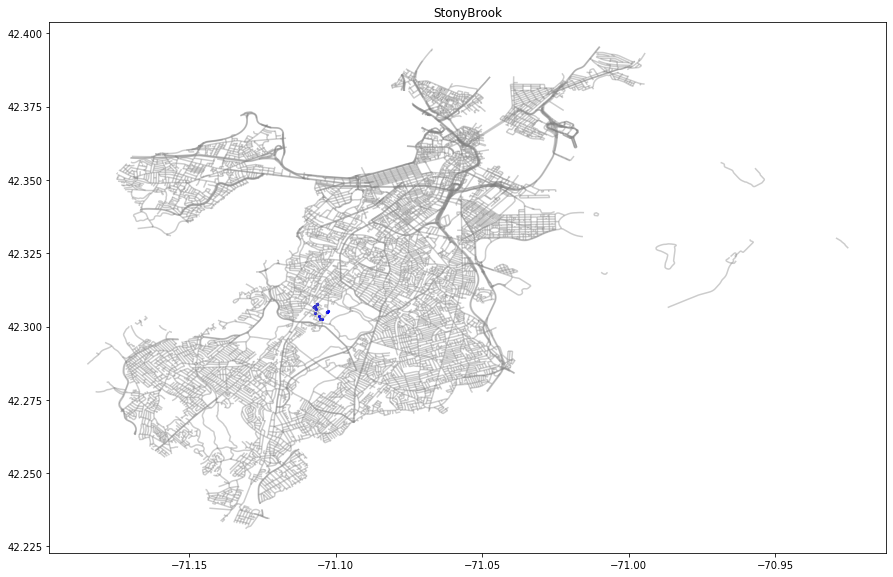

In [18]:
street_map = gpd.read_file('Boston_Street_Segments/Boston_Street_Segments.shp')
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax = ax, alpha = 0.4, color="grey")
stonybrook_acc.plot(ax = ax, markersize = 5, color="blue", marker="o",label="mv")
plt.title("StonyBrook")

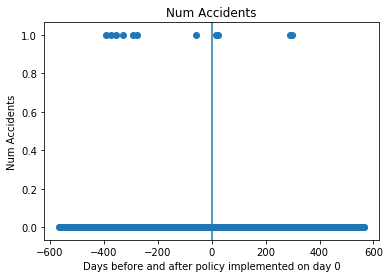

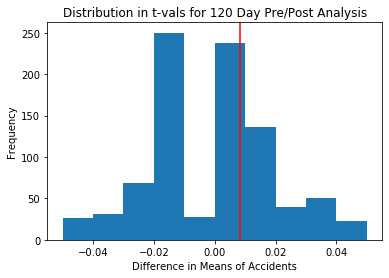

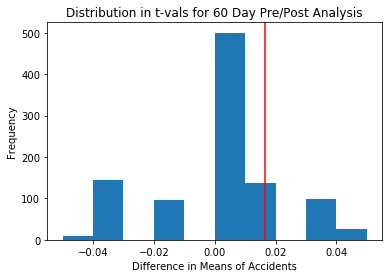

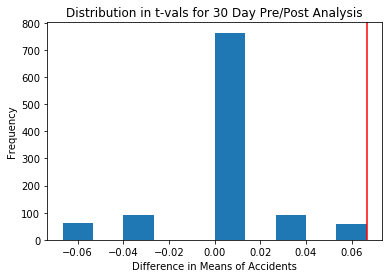

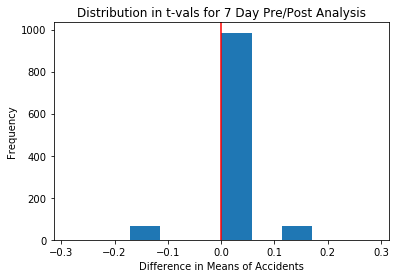

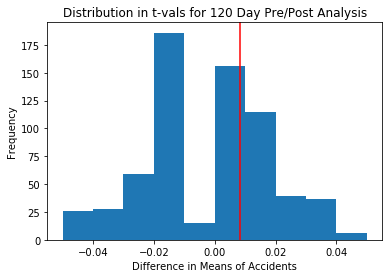

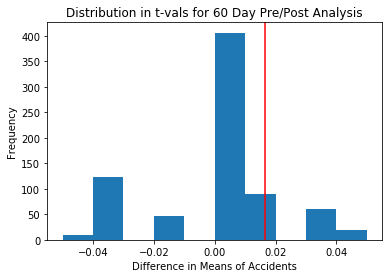

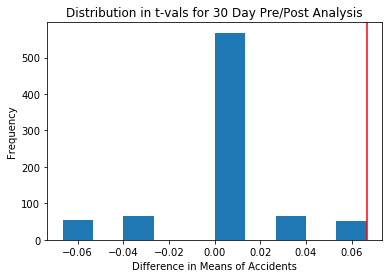

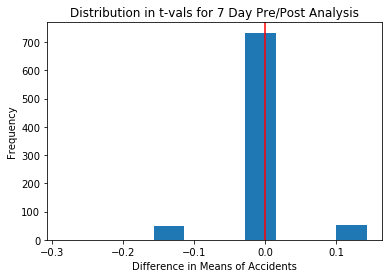

,interval,p_val,t_obs,p_val_filter,t_obs_filter
0,120 days,0.428571,0.008333,0.410795,0.008333
1,60 days,0.258672,0.016667,0.224868,0.016667
2,30 days,0.056127,0.066667,0.063670,0.066667
3,7 days,0.941704,0.000000,0.938995,0.000000


In [19]:
# plot results for all data
generate_accident_spread(stonybrook_diff_day)
p120, t120 = generate_results(stonybrook_diff_day, 120)
p60, t60 = generate_results(stonybrook_diff_day, 60)
p30, t30 = generate_results(stonybrook_diff_day, 30)
p7, t7 = generate_results(stonybrook_diff_day, 7)

# plot results for filtered data
p120_ft, t120_ft = generate_mahalanobis_results(stonybrook_diff_day, 120)
p60_ft, t60_ft = generate_mahalanobis_results(stonybrook_diff_day, 60)
p30_ft, t30_ft = generate_mahalanobis_results(stonybrook_diff_day, 30)
p7_ft, t7_ft = generate_mahalanobis_results(stonybrook_diff_day, 7)

data = [["120 days", p120, t120, p120_ft, t120_ft], 
        ["60 days", p60, t60, p60_ft, t60_ft], 
        ["30 days", p30, t30, p30_ft, t30_ft], 
        ["7 days", p7, t7, p7_ft, t7_ft]]
stonybrook_df = pd.DataFrame(data, columns = ['interval','p_val', 't_obs', 'p_val_filter', 't_obs_filter'])
stonybrook_df

# Neighborhood 2 - Talbot-Norfolk Triangle

Resouces: https://www.boston.gov/sites/default/files/embed/file/2018-06/2017-0926_nss_tnt_psande.pdf

In [20]:
p1 = (-71.077356, 42.291813)
p2 = (-71.078311, 42.289436)
p3 = (-71.077517, 42.285658)
p4 = (-71.074917, 42.286474)
p5 = (-71.071301, 42.287692)
p6 = (-71.071988, 42.290216)
implementation_date = '2018-06-15'
tnt_acc = points_in_region([p1, p2, p3, p4, p5, p6])
tnt_diff_day = groupby_implementation_date(tnt_acc, implementation_date)

Text(0.5, 1, 'Talbot-Norfolk Triangle')

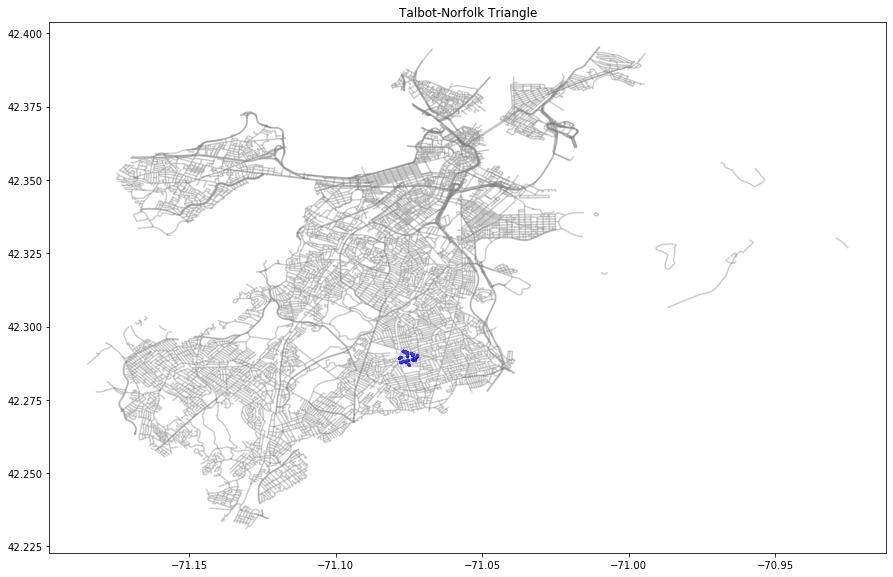

In [21]:
street_map = gpd.read_file('Boston_Street_Segments/Boston_Street_Segments.shp')
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax = ax, alpha = 0.4, color="grey")
tnt_acc.plot(ax = ax, markersize = 5, color="blue", marker="o",label="mv")
plt.title("Talbot-Norfolk Triangle")

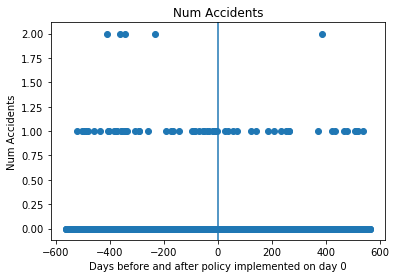

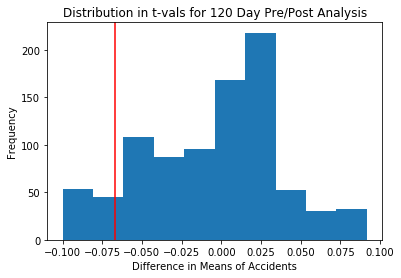

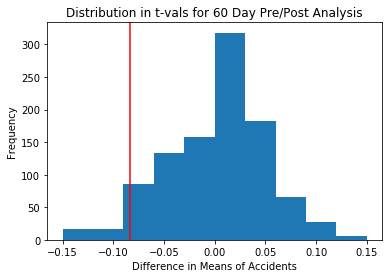

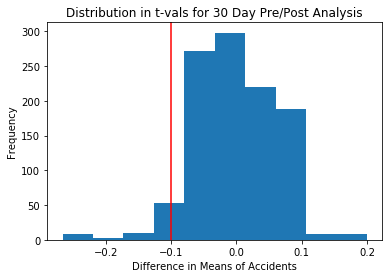

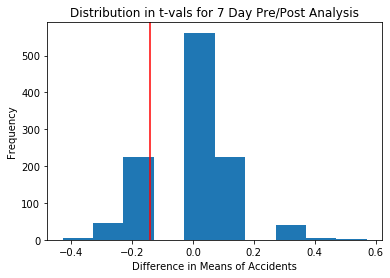

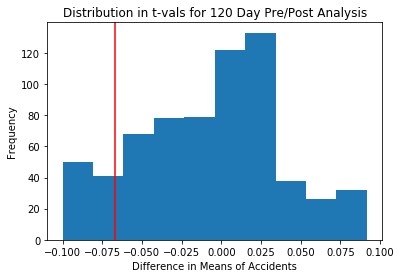

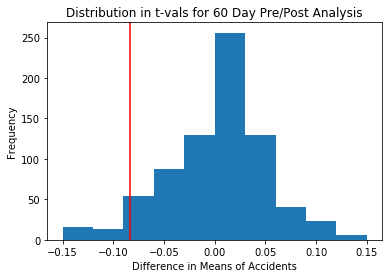

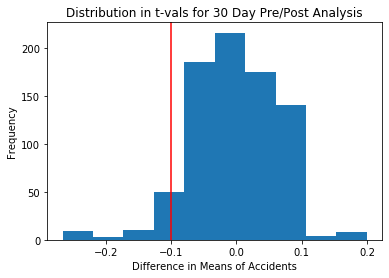

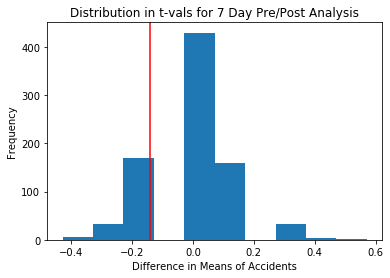

,interval,p_val,t_obs,p_val_filter,t_obs_filter
0,120 days,0.907762,-0.066667,0.881559,-0.066667
1,60 days,0.967294,-0.083333,0.961640,-0.083333
2,30 days,0.979420,-0.100000,0.972534,-0.100000
3,7 days,0.953363,-0.142857,0.953349,-0.142857


In [22]:
# plot results
generate_accident_spread(tnt_diff_day)
p120, t120 = generate_results(tnt_diff_day, 120)
p60, t60 = generate_results(tnt_diff_day, 60)
p30, t30 = generate_results(tnt_diff_day, 30)
p7, t7 = generate_results(tnt_diff_day, 7)

# plot results for filtered data
p120_ft, t120_ft = generate_mahalanobis_results(tnt_diff_day, 120)
p60_ft, t60_ft = generate_mahalanobis_results(tnt_diff_day, 60)
p30_ft, t30_ft = generate_mahalanobis_results(tnt_diff_day, 30)
p7_ft, t7_ft = generate_mahalanobis_results(tnt_diff_day, 7)

data = [["120 days", p120, t120, p120_ft, t120_ft], 
        ["60 days", p60, t60, p60_ft, t60_ft], 
        ["30 days", p30, t30, p30_ft, t30_ft], 
        ["7 days", p7, t7, p7_ft, t7_ft]]
tnt_df = pd.DataFrame(data, columns = ['interval','p_val', 't_obs', 'p_val_filter', 't_obs_filter'])
tnt_df

# Priority Corridor 1 - Beacon St
Links: https://www.boston.gov/departments/transportation/beacon-street-design-project

In [23]:
p1 = (-71.074919, 42.355030)
p2 = (-71.074726, 42.354665)
p3 = (-71.087086, 42.351692)
p4 = (-71.086914, 42.351335)
implementation_date = '2018-06-22'
beacon_acc = points_in_region([p1, p2, p3, p4])
beacon_diff_day = groupby_implementation_date(beacon_acc, implementation_date)

Text(0.5, 1, 'Beacon St')

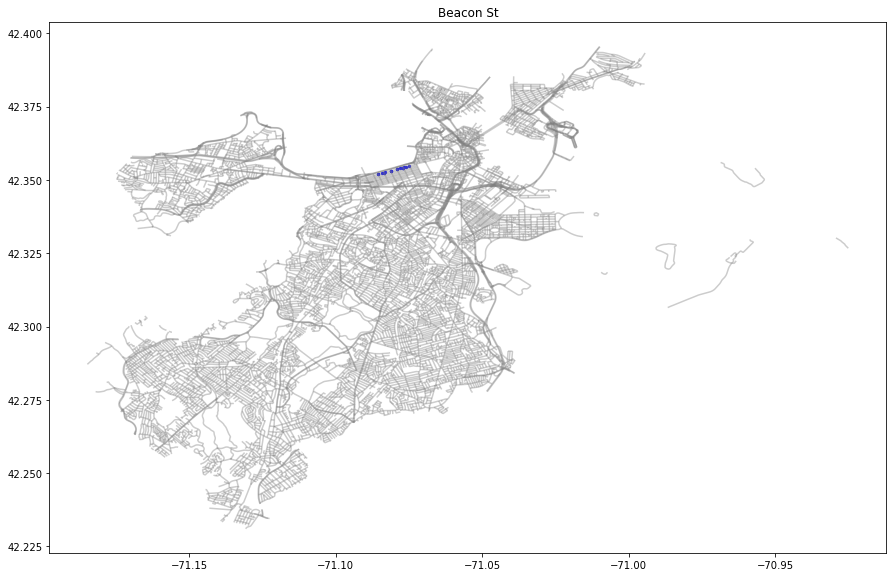

In [24]:
street_map = gpd.read_file('Boston_Street_Segments/Boston_Street_Segments.shp')
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax = ax, alpha = 0.4, color="grey")
beacon_acc.plot(ax = ax, markersize = 5, color="blue", marker="o",label="mv")
plt.title("Beacon St")

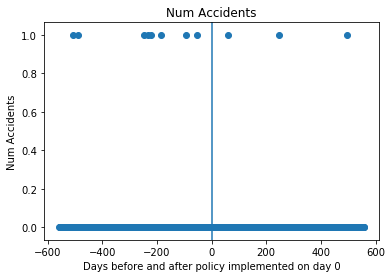

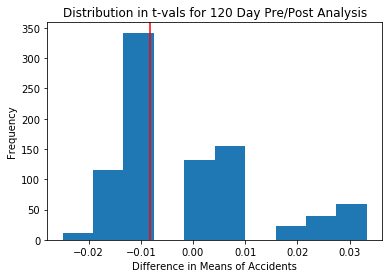

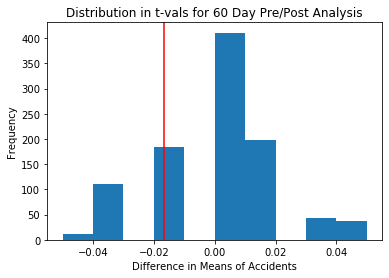

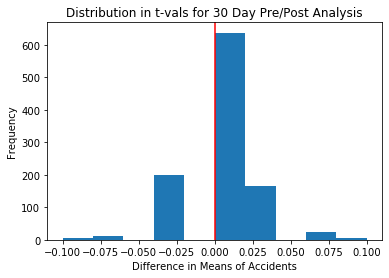

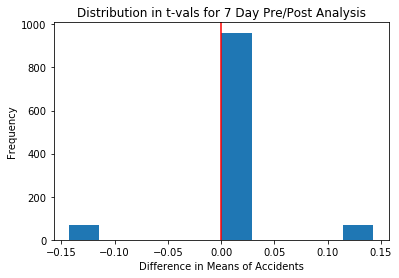

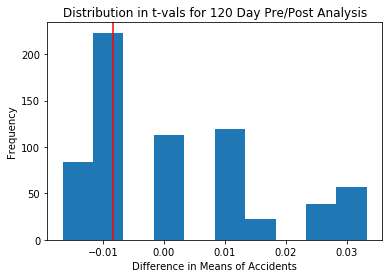

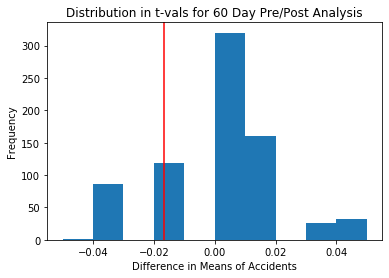

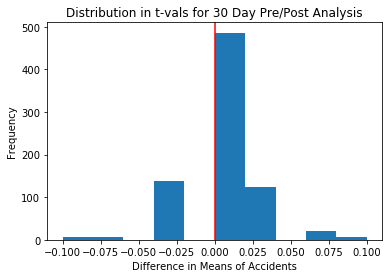

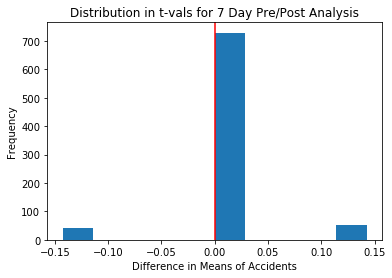

,interval,p_val,t_obs,p_val_filter,t_obs_filter
0,120 days,0.810286,-0.008333,0.826484,-0.008333
1,60 days,0.877387,-0.016667,0.882038,-0.016667
2,30 days,0.791469,0.000000,0.806574,0.000000
3,7 days,0.936421,0.000000,0.947879,0.000000


In [25]:
# plot results
generate_accident_spread(beacon_diff_day)
p120, t120 = generate_results(beacon_diff_day, 120)
p60, t60 = generate_results(beacon_diff_day, 60)
p30, t30 = generate_results(beacon_diff_day, 30)
p7, t7 = generate_results(beacon_diff_day, 7)

# plot results for filtered data
p120_ft, t120_ft = generate_mahalanobis_results(beacon_diff_day, 120)
p60_ft, t60_ft = generate_mahalanobis_results(beacon_diff_day, 60)
p30_ft, t30_ft = generate_mahalanobis_results(beacon_diff_day, 30)
p7_ft, t7_ft = generate_mahalanobis_results(beacon_diff_day, 7)

data = [["120 days", p120, t120, p120_ft, t120_ft], 
        ["60 days", p60, t60, p60_ft, t60_ft], 
        ["30 days", p30, t30, p30_ft, t30_ft], 
        ["7 days", p7, t7, p7_ft, t7_ft]]
beacon_df = pd.DataFrame(data, columns = ['interval','p_val', 't_obs', 'p_val_filter', 't_obs_filter'])
beacon_df

# Priority Corridor 2 - Mass Ave
Links: https://www.livablestreets.info/vision_zero_priority_corridor_mass_ave_public_meeting

In [26]:
p1 = (-71.089661, 42.350793)
p2 = (-71.085873, 42.343300)
p3 = (-71.075283, 42.334872)
p4 = (-71.074918, 42.335118)
p5 = (-71.085615, 42.343437)
p6 = (-71.089285, 42.350904) 
implementation_date = '2017-6-01'
mass_acc = points_in_region([p1, p2, p3, p4, p5, p6])
mass_diff_day = groupby_implementation_date(mass_acc, implementation_date)

Text(0.5, 1, 'Mass Ave')

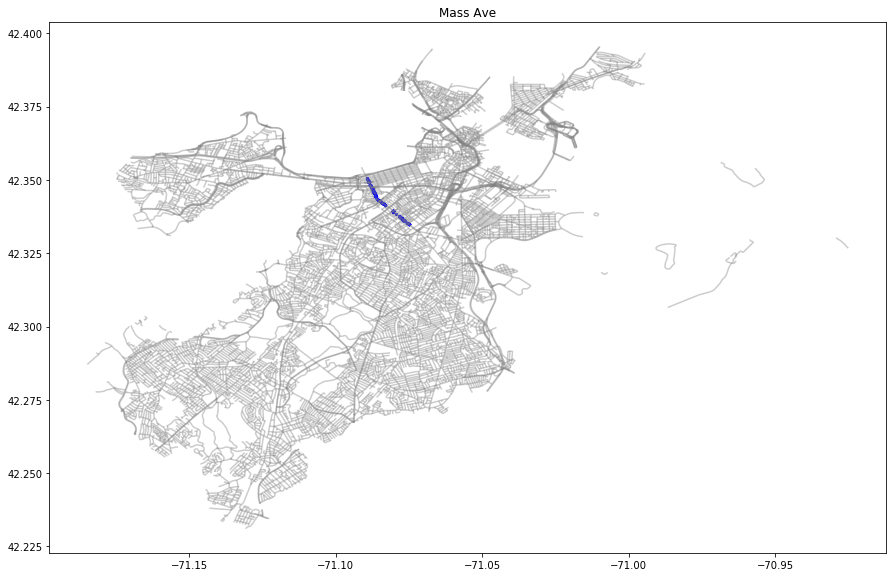

In [27]:
street_map = gpd.read_file('Boston_Street_Segments/Boston_Street_Segments.shp')
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax = ax, alpha = 0.4, color="grey")
mass_acc.plot(ax = ax, markersize = 5, color="blue", marker="o",label="mv")
plt.title("Mass Ave")

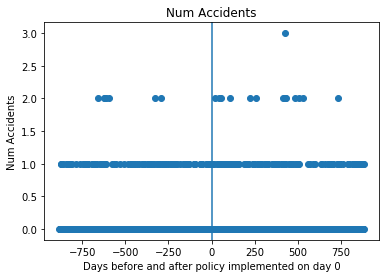

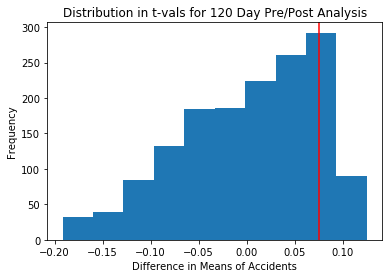

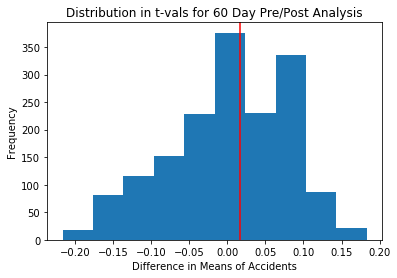

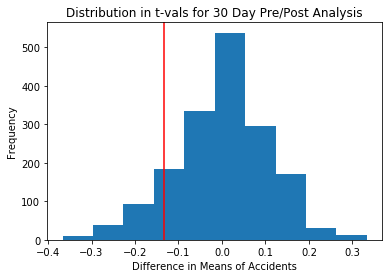

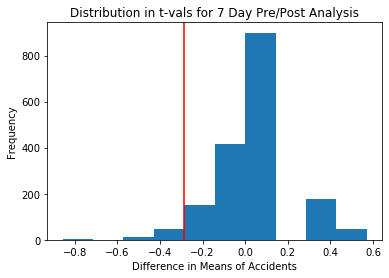

/Users/akshitharamachandran/anaconda3/envs/geopandas-test/lib/python3.7/site-packages/numpy/linalg/linalg.py:2125: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


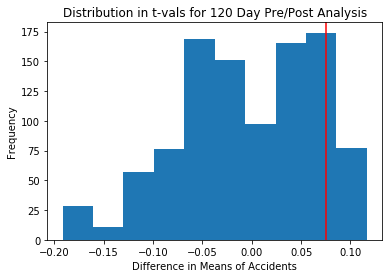

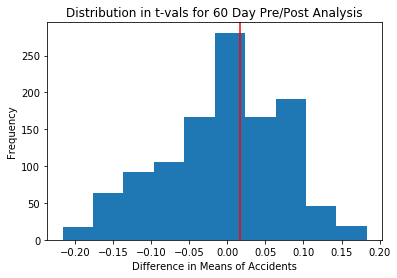

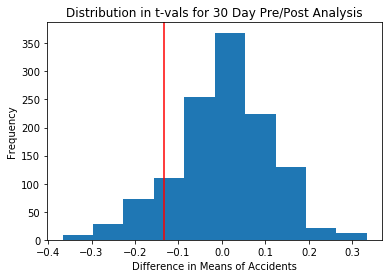

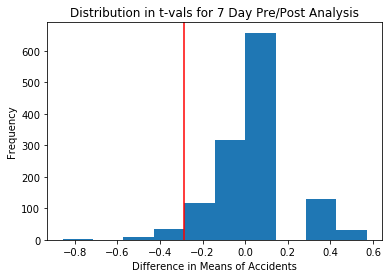

,interval,p_val,t_obs,p_val_filter,t_obs_filter
0,120 days,0.179672,0.075000,0.140299,0.075000
1,60 days,0.483891,0.016667,0.447254,0.016667
2,30 days,0.902053,-0.133333,0.896832,-0.133333
3,7 days,0.966305,-0.285714,0.964615,-0.285714


In [28]:
# plot results
generate_accident_spread(mass_diff_day)
p120, t120 = generate_results(mass_diff_day, 120)
p60, t60 = generate_results(mass_diff_day, 60)
p30, t30 = generate_results(mass_diff_day, 30)
p7, t7 = generate_results(mass_diff_day, 7)

# plot results for filtered data
p120_ft, t120_ft = generate_mahalanobis_results(mass_diff_day, 120)
p60_ft, t60_ft = generate_mahalanobis_results(mass_diff_day, 60)
p30_ft, t30_ft = generate_mahalanobis_results(mass_diff_day, 30)
p7_ft, t7_ft = generate_mahalanobis_results(mass_diff_day, 7)

data = [["120 days", p120, t120, p120_ft, t120_ft], 
        ["60 days", p60, t60, p60_ft, t60_ft], 
        ["30 days", p30, t30, p30_ft, t30_ft], 
        ["7 days", p7, t7, p7_ft, t7_ft]]
mass_df = pd.DataFrame(data, columns = ['interval','p_val', 't_obs', 'p_val_filter', 't_obs_filter'])
mass_df

# Priority Corridor 3 - Tremont St

In [29]:
p1 = (-71.068437, 42.347412)
p2 = (-71.068791, 42.347658)
p3 = (-71.070885, 42.344997)
p4 = (-71.070349, 42.344426)
p5 = (-71.086722, 42.335455)
p6 = (-71.087226, 42.335852)
p7 = (-71.068859, 42.346115)
implementation_date = '2018-10-01'
tremont_acc = points_in_region([p1, p2, p3, p4, p5, p6])
tremont_diff_day = groupby_implementation_date(tremont_acc, implementation_date)

Text(0.5, 1, 'Tremont St')

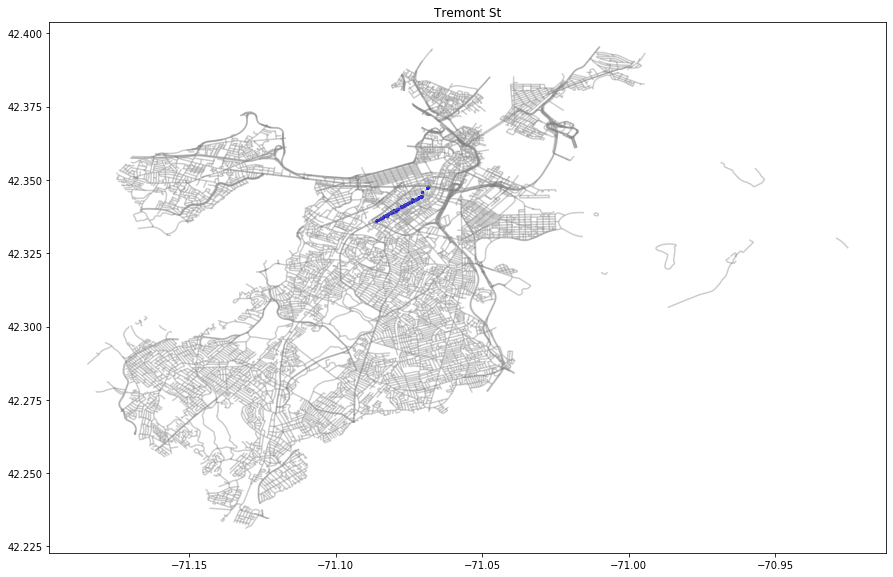

In [30]:
street_map = gpd.read_file('Boston_Street_Segments/Boston_Street_Segments.shp')
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax = ax, alpha = 0.4, color="grey")
tremont_acc.plot(ax = ax, markersize = 5, color="blue", marker="o",label="mv")
plt.title("Tremont St")

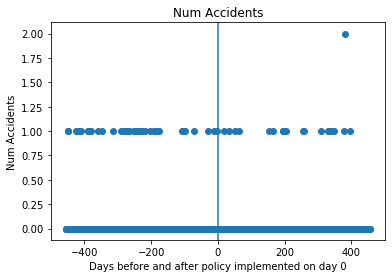

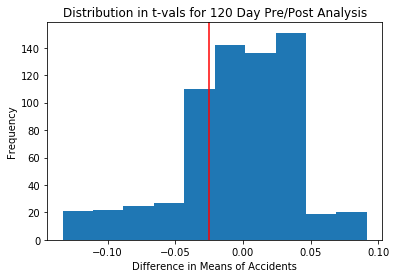

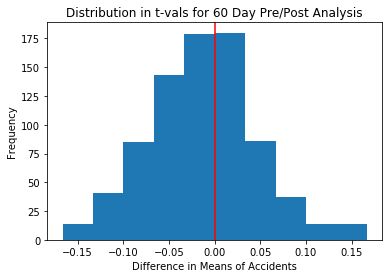

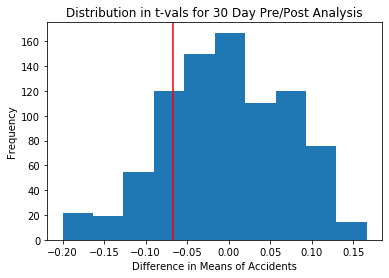

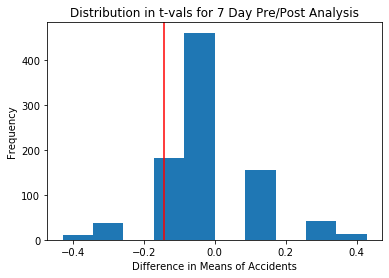

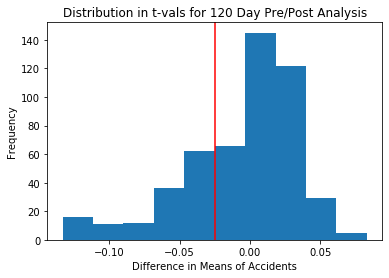

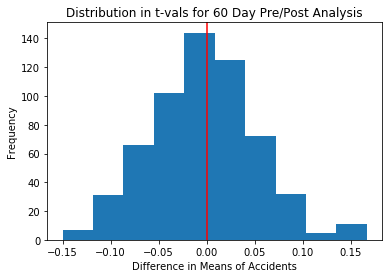

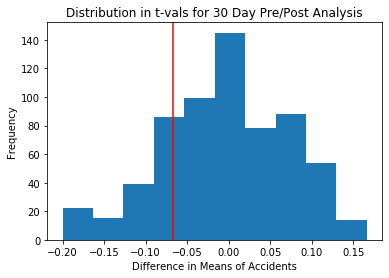

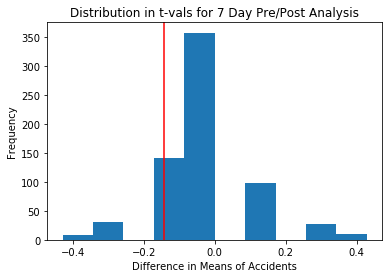

,interval,p_val,t_obs,p_val_filter,t_obs_filter
0,120 days,0.783061,-0.025000,0.793651,-0.025000
1,60 days,0.493064,0.000000,0.500840,0.000000
2,30 days,0.887456,-0.066667,0.881250,-0.066667
3,7 days,0.946607,-0.142857,0.942222,-0.142857


In [31]:
# plot results
generate_accident_spread(tremont_diff_day)
p120, t120 = generate_results(tremont_diff_day, 120)
p60, t60 = generate_results(tremont_diff_day, 60)
p30, t30 = generate_results(tremont_diff_day, 30)
p7, t7 = generate_results(tremont_diff_day, 7)

# plot results for filtered data
p120_ft, t120_ft = generate_mahalanobis_results(tremont_diff_day, 120)
p60_ft, t60_ft = generate_mahalanobis_results(tremont_diff_day, 60)
p30_ft, t30_ft = generate_mahalanobis_results(tremont_diff_day, 30)
p7_ft, t7_ft = generate_mahalanobis_results(tremont_diff_day, 7)

data = [["120 days", p120, t120, p120_ft, t120_ft], 
        ["60 days", p60, t60, p60_ft, t60_ft], 
        ["30 days", p30, t30, p30_ft, t30_ft], 
        ["7 days", p7, t7, p7_ft, t7_ft]]
tremont_df = pd.DataFrame(data, columns = ['interval','p_val', 't_obs', 'p_val_filter', 't_obs_filter'])
tremont_df

# Priority Corridor 4 - Kneeland St

In [32]:
p1 = (-71.056933, 42.349738)
p2 = (-71.057212, 42.349334)
p3 = (-71.063091, 42.350761)
p4 = (-71.062962, 42.351070)
implementation_date = '2018-10-01'
kneeland_acc = points_in_region([p1, p2, p3, p4])
kneeland_diff_day = groupby_implementation_date(kneeland_acc, implementation_date)

Text(0.5, 1, 'Kneeland St')

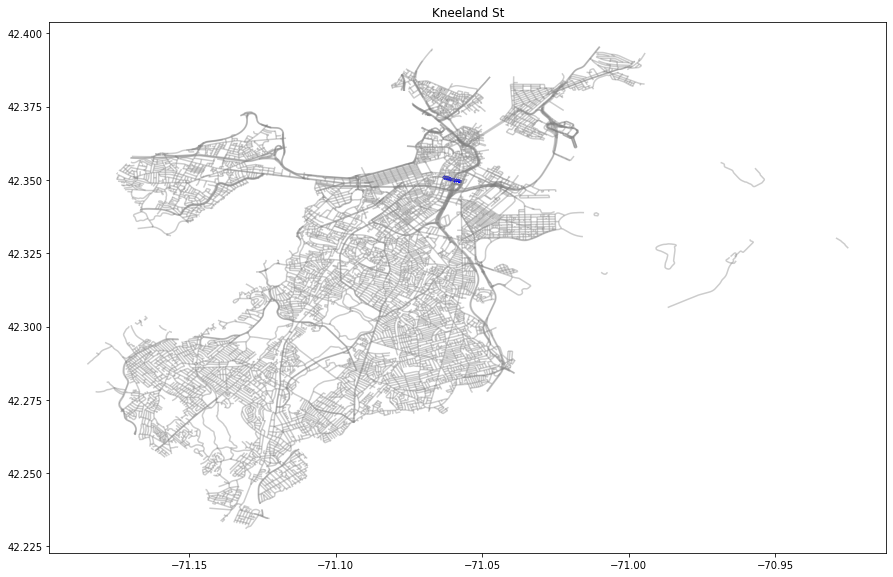

In [33]:
street_map = gpd.read_file('Boston_Street_Segments/Boston_Street_Segments.shp')
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax = ax, alpha = 0.4, color="grey")
kneeland_acc.plot(ax = ax, markersize = 5, color="blue", marker="o",label="mv")
plt.title("Kneeland St")

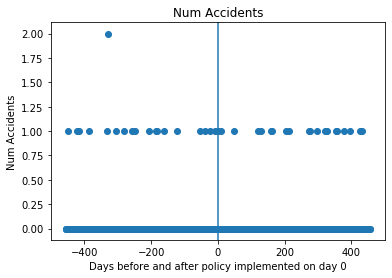

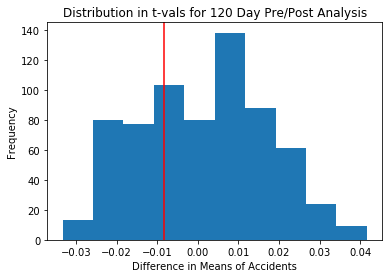

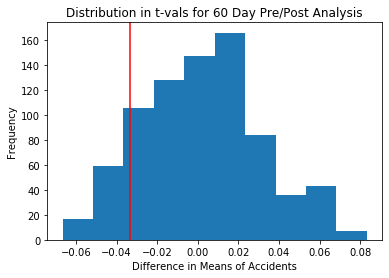

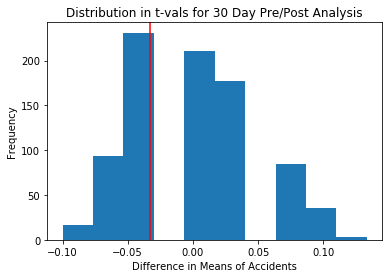

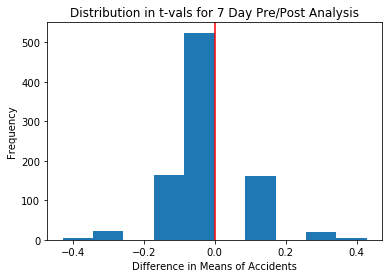

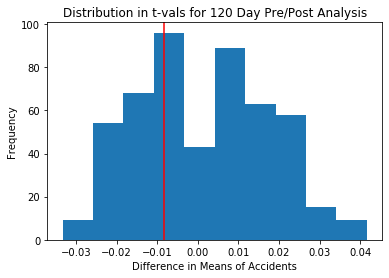

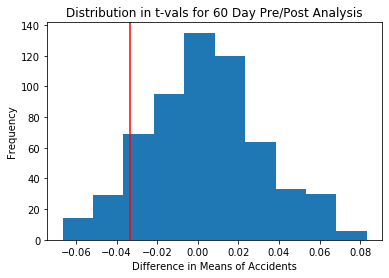

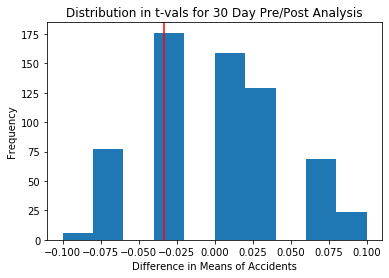

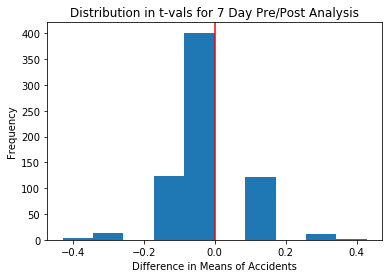

,interval,p_val,t_obs,p_val_filter,t_obs_filter
0,120 days,0.658247,-0.008333,0.626984,-0.008333
1,60 days,0.842371,-0.033333,0.860504,-0.033333
2,30 days,0.851114,-0.033333,0.853125,-0.033333
3,7 days,0.788654,0.000000,0.792593,0.000000


In [34]:
# plot results
generate_accident_spread(kneeland_diff_day)
p120, t120 = generate_results(kneeland_diff_day, 120)
p60, t60 = generate_results(kneeland_diff_day, 60)
p30, t30 = generate_results(kneeland_diff_day, 30)
p7, t7 = generate_results(kneeland_diff_day, 7)

# plot results for filtered data
p120_ft, t120_ft = generate_mahalanobis_results(kneeland_diff_day, 120)
p60_ft, t60_ft = generate_mahalanobis_results(kneeland_diff_day, 60)
p30_ft, t30_ft = generate_mahalanobis_results(kneeland_diff_day, 30)
p7_ft, t7_ft = generate_mahalanobis_results(kneeland_diff_day, 7)

data = [["120 days", p120, t120, p120_ft, t120_ft], 
        ["60 days", p60, t60, p60_ft, t60_ft], 
        ["30 days", p30, t30, p30_ft, t30_ft], 
        ["7 days", p7, t7, p7_ft, t7_ft]]
kneeland_df = pd.DataFrame(data, columns = ['interval','p_val', 't_obs', 'p_val_filter', 't_obs_filter'])
kneeland_df